# Анализ временных рядов с использованием Python (сырье PET)
статья (https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/)

## Загрузим исходные данные из файла

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [86]:
data = pd.read_excel("data_pet.xlsx", 0, index_col='Date')
data.dropna(inplace=True)
print(data.head())
print('\n Data Types:')
print(data.dtypes)

               PET    Oil
Date                     
2005-03-01  1280.0  49.83
2005-04-01  1280.0  50.60
2005-05-01  1110.0  50.25
2005-06-01  1050.0  56.60
2005-07-01  1050.0  58.66

 Data Types:
PET    float64
Oil    float64
dtype: object


Для анализа возьмем стоимость нефти номенированную по текущему курсу доллара (первая колонка файла), округли и отфильтруем данные.

In [88]:
ts = data[data.columns[0]]['2005-03-01':'2016-12-01'].astype(np.int64)
ts.head(10)

Date
2005-03-01    1280
2005-04-01    1280
2005-05-01    1110
2005-06-01    1050
2005-07-01    1050
2005-08-01    1060
2005-09-01    1160
2005-10-01    1190
2005-11-01    1090
2005-12-01    1030
Name: PET, dtype: int64

# Проверка на стационарность

## Выведем  график исходных данных

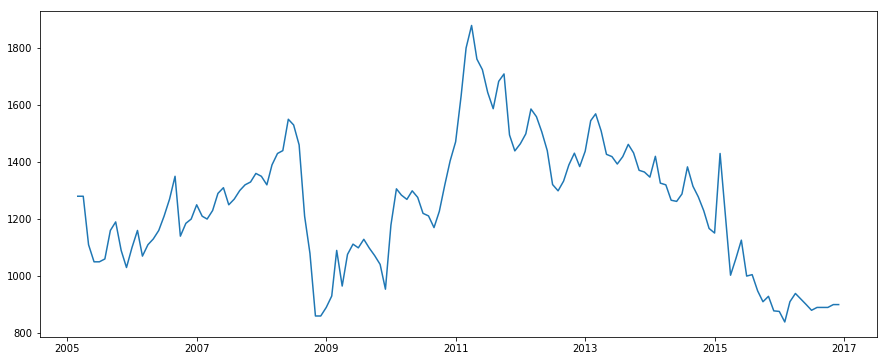

In [89]:
plt.plot(ts)

### Функция для тестирования стационарности

Тест Дики-Фуллера (http://ru.wikipedia.org/wiki/Тест_Дики_—_Фуллера)

In [90]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    if dfoutput[0] > dfoutput[4]:
        print('Time series is''nt stationar')
    else:
        print('Time series is stationar')

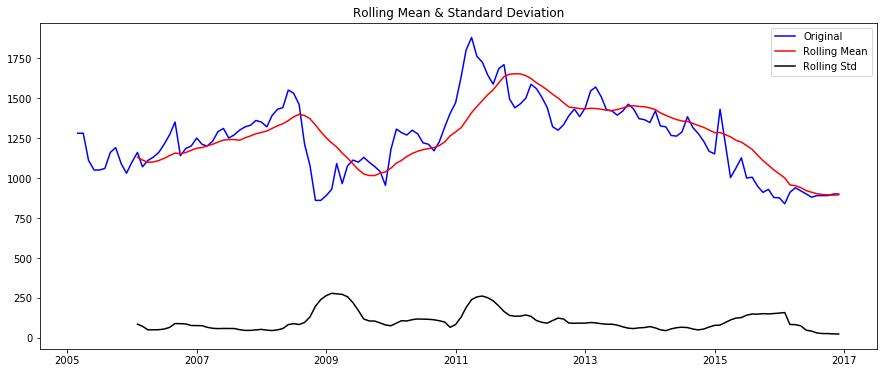

Results of Dickey-Fuller Test:
Test Statistic                  -2.002618
p-value                          0.285427
#Lags Used                       0.000000
Number of Observations Used    140.000000
Critical Value (5%)             -2.882416
Critical Value (10%)            -2.577902
Critical Value (1%)             -3.477945
dtype: float64
Time series isnt stationar


In [91]:
test_stationarity(ts)

# Конвертация данных в стационарные

Попытамся обработать данные так, чтобы они сформированили устойчевые, стационарные структуры


## Выравнивание данных


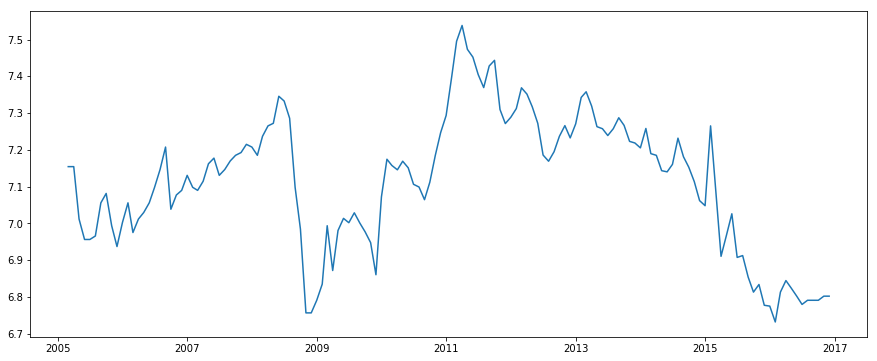

In [92]:
ts_log = np.log(ts)
ts_log.fillna(0, inplace=True)
plt.plot(ts_log)

In [93]:
ts_log.head()

Date
2005-03-01    7.154615
2005-04-01    7.154615
2005-05-01    7.012115
2005-06-01    6.956545
2005-07-01    6.956545
Name: PET, dtype: float64

## Сглаживание:

### Скользящая средняя

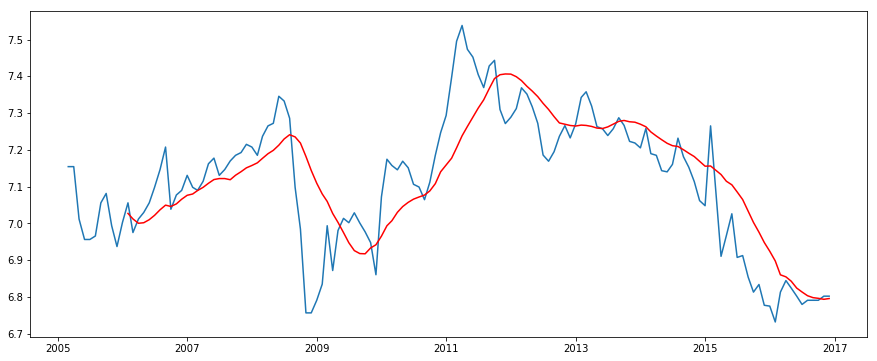

In [94]:
moving_avg = ts_log.rolling(12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

проверим на стационарность

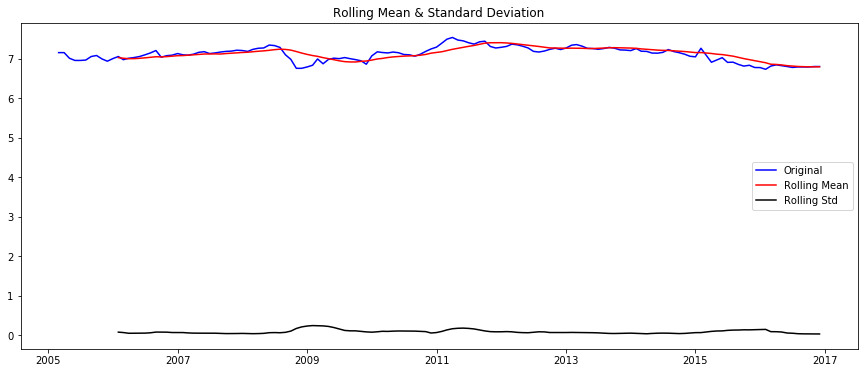

Results of Dickey-Fuller Test:
Test Statistic                  -1.959708
p-value                          0.304514
#Lags Used                       0.000000
Number of Observations Used    140.000000
Critical Value (5%)             -2.882416
Critical Value (10%)            -2.577902
Critical Value (1%)             -3.477945
dtype: float64
Time series isnt stationar


In [95]:
test_stationarity(ts_log)

In [96]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(12)

Date
2005-03-01         NaN
2005-04-01         NaN
2005-05-01         NaN
2005-06-01         NaN
2005-07-01         NaN
2005-08-01         NaN
2005-09-01         NaN
2005-10-01         NaN
2005-11-01         NaN
2005-12-01         NaN
2006-01-01         NaN
2006-02-01    0.028773
Name: PET, dtype: float64

уберем пустые значения (NaN)

In [97]:
ts_log_moving_avg_diff.dropna(inplace=True)
ts_log_moving_avg_diff.head()

Date
2006-02-01    0.028773
2006-03-01   -0.037055
2006-04-01    0.011521
2006-05-01    0.027891
2006-06-01    0.045790
Name: PET, dtype: float64

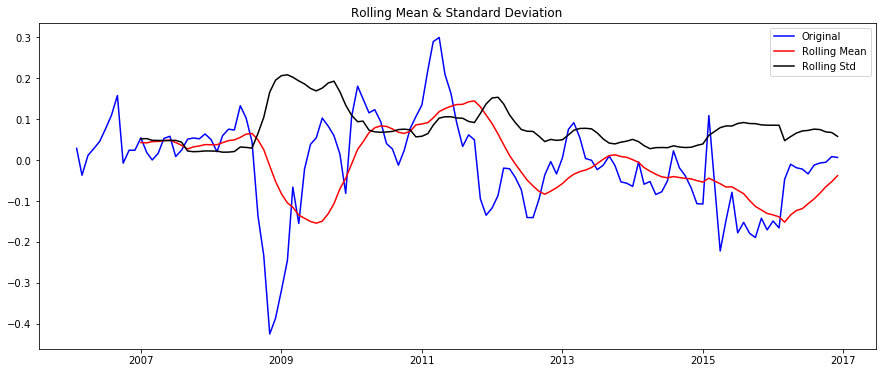

Results of Dickey-Fuller Test:
Test Statistic                  -3.471480
p-value                          0.008750
#Lags Used                       0.000000
Number of Observations Used    129.000000
Critical Value (5%)             -2.884219
Critical Value (10%)            -2.578864
Critical Value (1%)             -3.482088
dtype: float64
Time series is stationar


In [98]:
test_stationarity(ts_log_moving_avg_diff)

результат хуже чем для ts_log

### Exponentially Weighted Moving Average

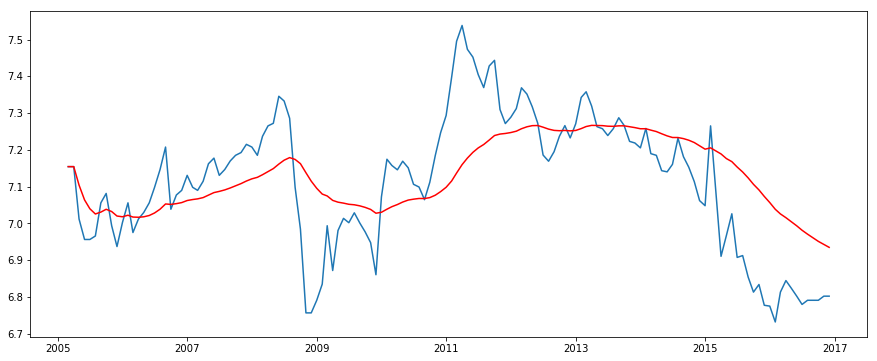

In [41]:
expwighted_avg = ts_log.ewm(halflife=12).mean()
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')
# expwighted_avg.plot(style='k--')

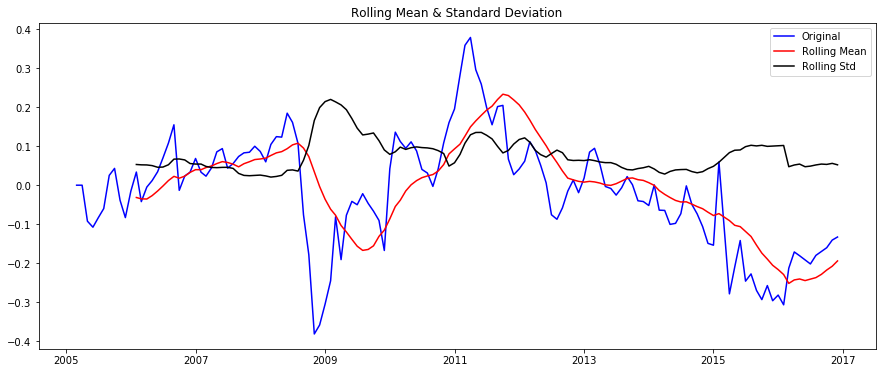

Results of Dickey-Fuller Test:
Test Statistic                  -2.770236
p-value                          0.062653
#Lags Used                       0.000000
Number of Observations Used    140.000000
Critical Value (5%)             -2.882416
Critical Value (10%)            -2.577902
Critical Value (1%)             -3.477945
dtype: float64


In [42]:
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)

## Удаление тренда и сезонности

### Дифференциация:

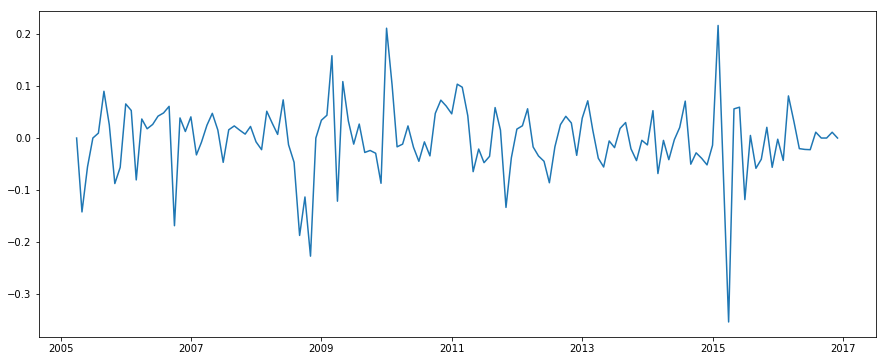

In [43]:
#Take first difference:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

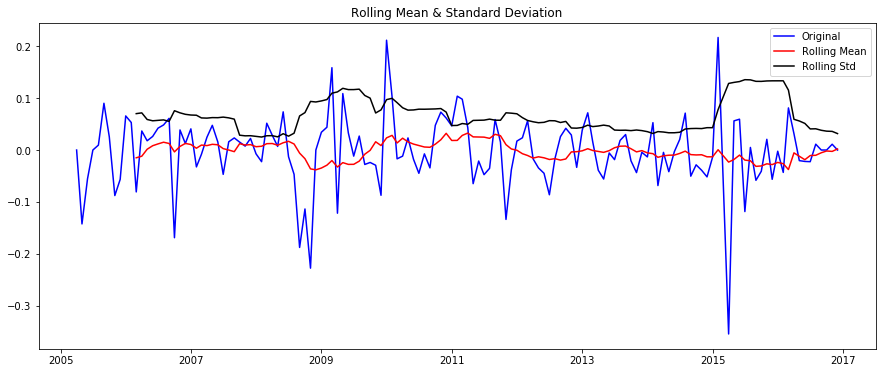

Results of Dickey-Fuller Test:
Test Statistic                -1.208903e+01
p-value                        2.143915e-22
#Lags Used                     0.000000e+00
Number of Observations Used    1.390000e+02
Critical Value (5%)           -2.882568e+00
Critical Value (10%)          -2.577983e+00
Critical Value (1%)           -3.478294e+00
dtype: float64


In [44]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

### Декомпозиция:

In [45]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

ValueError: You must specify a freq or x must be a pandas object with a timeseries index witha freq not set to None

In [46]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

NameError: name 'residual' is not defined

In [47]:
ts_log_decompose.head()

NameError: name 'ts_log_decompose' is not defined

# Подбор модели для предсказания

### ARIMA модель:

Подберем параметры p,q,d модели

In [48]:
from statsmodels.tsa.arima_model import ARIMA

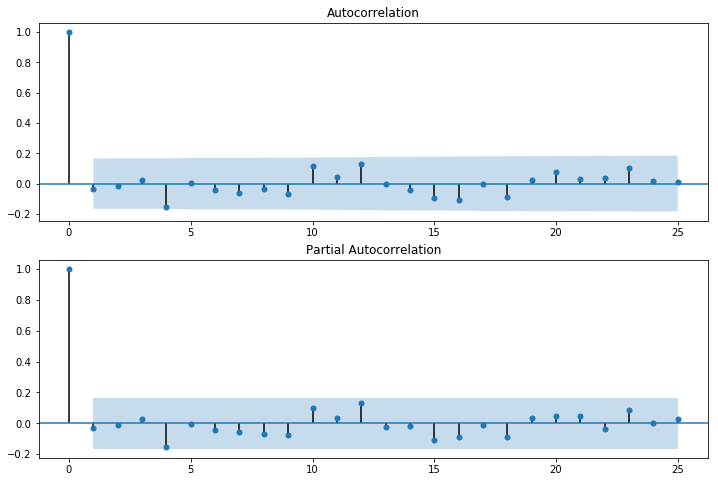

In [49]:
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts_log_diff.values.squeeze(), lags=25, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts_log_diff, lags=25, ax=ax2)

In [50]:
def ARIMA_model(timesries, timesries_diff, p, d, q):
    model = ARIMA(timesries, order=(p, d, q))  
    results_ = model.fit(disp=-1)  
    plt.plot(timesries_diff)
    plt.plot(results_.fittedvalues, color='red')
    plt.title('RSS: %.4f'% sum((results_.fittedvalues-timesries_diff)**2))
    return results_

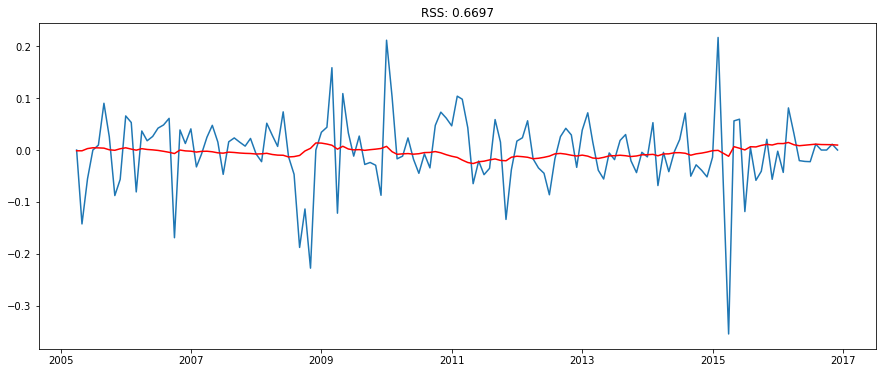

In [51]:
results_ARIMA = ARIMA_model(ts_log,ts_log_diff,p=1,d=1,q=1)

### Сравнение предсказания и исходных данных:

In [52]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

Date
2005-04-01   -0.001447
2005-05-01   -0.001489
2005-06-01    0.002785
2005-07-01    0.004350
2005-08-01    0.004147
dtype: float64


In [53]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

Date
2005-04-01   -0.001447
2005-05-01   -0.002936
2005-06-01   -0.000151
2005-07-01    0.004198
2005-08-01    0.008345
dtype: float64


In [54]:
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Date
2005-03-01    7.154615
2005-04-01    7.153169
2005-05-01    7.151679
2005-06-01    7.154464
2005-07-01    7.158814
dtype: float64

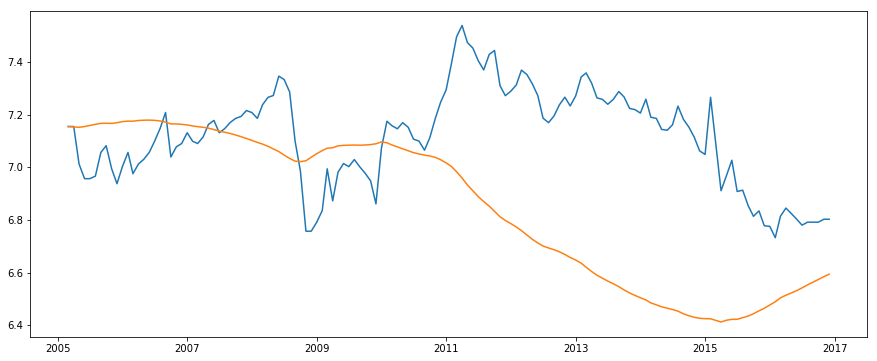

In [55]:
plt.plot(ts_log)
plt.plot(predictions_ARIMA_log)

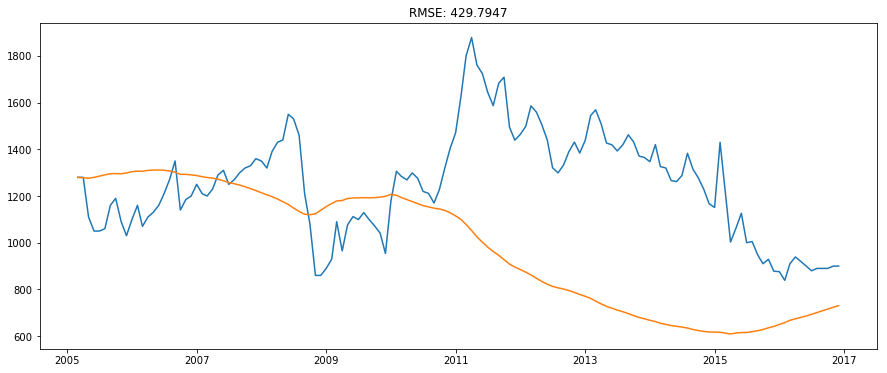

In [56]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))

Анализ не дал высокой точности предсказания. Возможно, что модель просто не может обеспечить на тех данных которые доступны нормальное предсказание и нужны дополнительные параметры, которые уточнят модель.